## **Data Cleaning**
#### - This is to clean the database by dropping unnecessary columns and filtering 2018~2021

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DSO 574/Assignment 2/Database/2019-2020 NBA Play-By-Play Data.csv')

<ipython-input-5-303547dd4603>:1: DtypeWarning: Columns (40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/DSO 574/Assignment 2/Database/2019-2020 NBA Play-By-Play Data.csv')


In [ ]:
df['result'].value_counts()

made      134082
missed    121313
Name: result, dtype: int64

In [ ]:
df['type'].value_counts().head(20)

rebound defensive      81620
sub                    55834
Jump Shot              43405
unknown                32018
3PT Jump Shot          26071
rebound offensive      25110
s.foul                 22429
Free Throw 1 of 2      21327
Free Throw 2 of 2      21307
Pullup Jump Shot       18147
p.foul                 15758
team rebound           14575
Layup                  10979
Driving Layup           8019
 timeout: regular       7269
bad pass                6511
bad pass                6439
Step Back Jump Shot     6410
Free Throw 1 of 1       5581
timeout: regular        5442
Name: type, dtype: int64

In [ ]:
df['description'].head(30)

0                                                   NaN
1           Jump Ball Towns vs. Jokic: Tip to Covington
2     Wiggins 1' Cutting Dunk Shot (2 PTS) (Towns 1 ...
3     Jokic 6' Driving Floating Bank Jump Shot (2 PT...
4                         MISS Graham 25' 3PT Jump Shot
5                           Jokic REBOUND (Off:0 Def:1)
6                          MISS Jokic 25' 3PT Jump Shot
7                          Graham REBOUND (Off:0 Def:1)
8                         MISS Culver 27' 3PT Jump Shot
9                         Millsap REBOUND (Off:0 Def:1)
10    Murray 5' Cutting Layup Shot (2 PTS) (Jokic 1 ...
11         Towns  Driving Layup (2 PTS) (Wiggins 1 AST)
12     MISS Jokic 7' Hook Shot, Covington BLOCK (1 BLK)
13                         Culver REBOUND (Off:0 Def:1)
14                              Culver 1' Layup (2 PTS)
15                   Barton 10' Fadeaway Jumper (2 PTS)
16               Towns 26' 3PT Pullup Jump Shot (5 PTS)
17                        Jokic 1' Driving Dunk 

In [ ]:
## find Lakers game
lakers = df[df['GameFile'].str.contains("LAL")]
lakers.shape

(43496, 46)

In [ ]:
col = ['a1', 'a2', 'a3', 'a4', 'a5', 'h1', 'h2', 'h3', 'h4', 'h5']

lebron_mask = df[col].apply(lambda row: 'LeBron James' in row.values, axis=1)
anthony_davis_mask = df[col].apply(lambda row: 'Anthony Davis' in row.values, axis=1)

# Filter the DataFrame for rows where both LeBron James and Anthony Davis are on the court
lebron_and_anthony_davis = df[lebron_mask & anthony_davis_mask]

In [ ]:
# Using this code, we can browse all the columns
pd.set_option('display.max_columns', None)

In [ ]:
lebron_and_anthony_davis.shape

(19484, 46)

##**Part A**
#### Time series for both star players on court

#### Count number of times ***Lebron James*** is on the court

In [ ]:
lebron_on_court = lakers[lebron_mask]

<ipython-input-13-e4e2d7e073f9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lebron_on_court = lakers[lebron_mask]


In [ ]:
lebron_on_court = lebron_on_court.copy()

# Extract minutes from 'elapsed' timestamp
lebron_on_court['minute'] = lebron_on_court['elapsed'].apply(
    lambda x: x[x.find(':') + 1:x.find(':') + 3] if np.any(lebron_on_court['period'] == 5) else x[x.find(':') + 1:x.find(':') + 3]
)

In [ ]:
# Combine 12 to 11 category (the elapsed timestamp of 12 minute is 00:12:00 so it should be categorized as 11-minute category)
lebron_on_court['minute'].replace('12', '11', inplace=True)

In [ ]:
# Focus on-court time
lbj_time = lebron_on_court[['period','minute','GameFile']]

In [ ]:
lbj_time.drop_duplicates(subset=['period', 'minute', 'GameFile'], keep='first', inplace=True)

<ipython-input-17-24da94e1232e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lbj_time.drop_duplicates(subset=['period', 'minute', 'GameFile'], keep='first', inplace=True)


In [ ]:
# Calculate the number of times Lbj and AD are both on the court based on the minute count.
lbj_time = lbj_time.groupby(['period', 'minute']).size().reset_index(name='both_on_court')

In [ ]:
# Divide by the total number of games in which both of them played
# 88 stands for the number of games Lebron played on the court
lbj_time['percentage'] = lbj_time['both_on_court'] / 88

In [ ]:
lbj_time.sort_values(by=['period', 'minute'], inplace=True)

# Create a new column 'rank' starting from 1
lbj_time['Game Minute'] = range(1, len(lbj_time) + 1)

In [ ]:
lbj_time = lbj_time[lbj_time['period'] != 5]

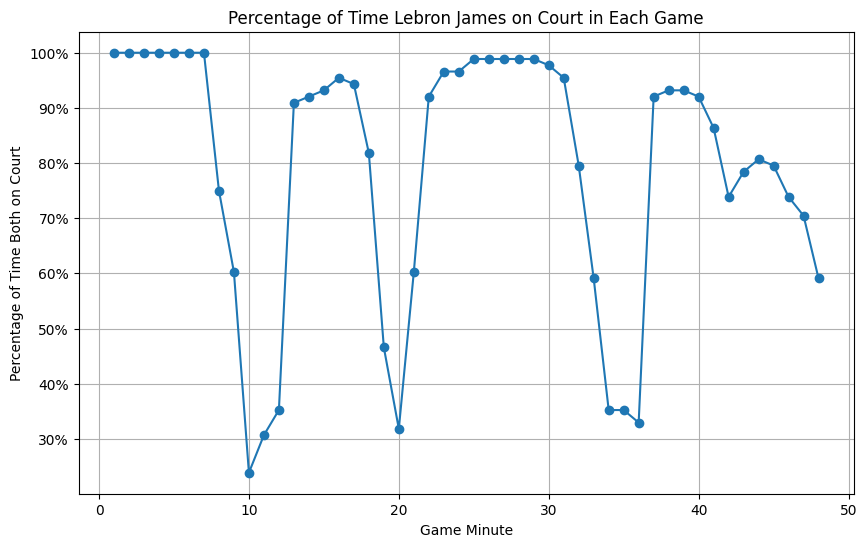

In [ ]:
# Ensure 'rank' and 'percentage' are numeric types
lbj_time['Game Minute'] = pd.to_numeric(lbj_time['Game Minute'])
lbj_time['percentage'] = pd.to_numeric(lbj_time['percentage'])

# Function to format y-axis ticks as percentages
def percent_formatter(x, pos):
    return f'{x:.0%}'

# Time Series Plot
plt.figure(figsize=(10, 6))
plt.plot(lbj_time['Game Minute'], lbj_time['percentage'], marker='o', linestyle='-')
plt.title('Percentage of Time Lebron James on Court in Each Game')
plt.xlabel('Game Minute')
plt.ylabel('Percentage of Time Both on Court')

# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.grid(True)
plt.show()

#### Count number of times ***Anthony Davis*** is on the court

In [ ]:
ad_on_court = lakers[anthony_davis_mask]

<ipython-input-78-8bf03a78deb3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ad_on_court = lakers[anthony_davis_mask]


In [ ]:
ad_on_court = ad_on_court.copy()

# Extract minutes from 'elapsed' timestamp
ad_on_court['minute'] = ad_on_court['elapsed'].apply(
    lambda x: x[x.find(':') + 1:x.find(':') + 3] if np.any(ad_on_court['period'] == 5) else x[x.find(':') + 1:x.find(':') + 3]
)

In [ ]:
# Combine 12 to 11 category (the elapsed timestamp of 12 minute is 00:12:00 so it should be categorized as 11-minute category)
ad_on_court['minute'].replace('12', '11', inplace=True)

In [ ]:
# Focus on-court time
ad_time = ad_on_court[['period','minute','GameFile']]

In [ ]:
ad_time.drop_duplicates(subset=['period', 'minute', 'GameFile'], keep='first', inplace=True)

<ipython-input-82-512ae66cf2f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_time.drop_duplicates(subset=['period', 'minute', 'GameFile'], keep='first', inplace=True)


In [ ]:
# Calculate the number of times Lbj and AD are both on the court based on the minute count.
ad_time = ad_time.groupby(['period', 'minute']).size().reset_index(name='both_on_court')

In [ ]:
ad_time.head()

,period,minute,both_on_court
0,1,00,83
1,1,01,83
2,1,02,82
3,1,03,82
4,1,04,81


In [ ]:
# Divide by the total number of games in which both of them played
# 83 stands for the number of games A. Davis played on the court at the same time
ad_time['percentage'] = ad_time['both_on_court'] / 83

In [ ]:
ad_time.sort_values(by=['period', 'minute'], inplace=True)

# Create a new column 'rank' starting from 1
ad_time['Game Minute'] = range(1, len(ad_time) + 1)

In [ ]:
ad_time = ad_time[ad_time['period'] != 5]

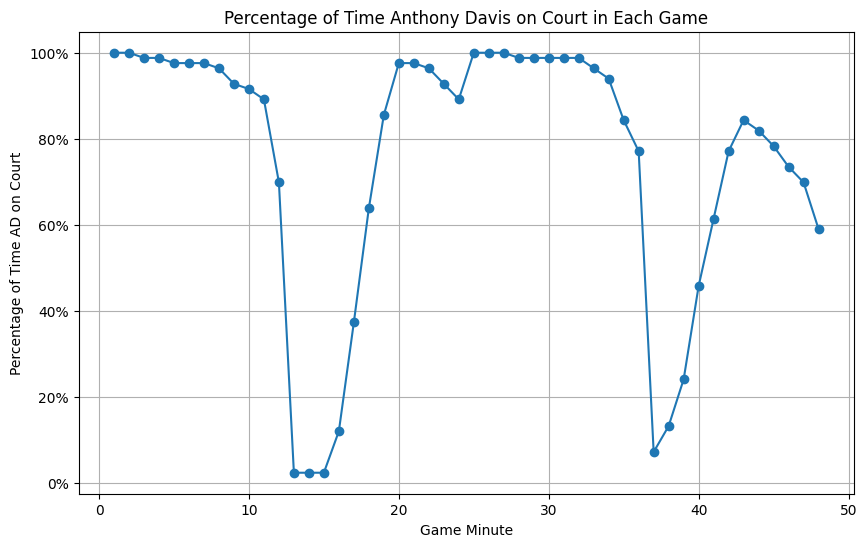

In [ ]:
# Ensure 'rank' and 'percentage' are numeric types
ad_time['Game Minute'] = pd.to_numeric(ad_time['Game Minute'])
ad_time['percentage'] = pd.to_numeric(ad_time['percentage'])

# Function to format y-axis ticks as percentages
def percent_formatter(x, pos):
    return f'{x:.0%}'

# Time Series Plot
plt.figure(figsize=(10, 6))
plt.plot(ad_time['Game Minute'], ad_time['percentage'], marker='o', linestyle='-')
plt.title('Percentage of Time Anthony Davis on Court in Each Game')
plt.xlabel('Game Minute')
plt.ylabel('Percentage of Time AD on Court')

# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.grid(True)
plt.show()

#### Count number of times ***Lbj and AD*** are both on the court

In [ ]:
lebron_and_anthony_davis = lebron_and_anthony_davis.copy()

# Extract minutes from 'elapsed' timestamp
lebron_and_anthony_davis['minute'] = lebron_and_anthony_davis['elapsed'].apply(
    lambda x: x[x.find(':') + 1:x.find(':') + 3] if np.any(lebron_and_anthony_davis['period'] == 5) else x[x.find(':') + 1:x.find(':') + 3]
)

In [ ]:
# Combine 12 to 11 category (the elapsed timestamp of 12 minute is 00:12:00 so it should be categorized as 11-minute category)
lebron_and_anthony_davis['minute'].replace('12', '11', inplace=True)

In [ ]:
# Focus on-court time
lbj_ad_time = lebron_and_anthony_davis[['period','minute','GameFile']]

In [ ]:
lbj_ad_time.drop_duplicates(subset=['period', 'minute', 'GameFile'], keep='first', inplace=True)

<ipython-input-66-393bfa8f70e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lbj_ad_time.drop_duplicates(subset=['period', 'minute', 'GameFile'], keep='first', inplace=True)


In [ ]:
# Calculate the number of times Lbj and AD are both on the court based on the minute count.
lbj_ad_time = lbj_ad_time.groupby(['period', 'minute']).size().reset_index(name='both_on_court')

In [ ]:
# Divide by the total number of games in which both of them played
# 80 stands for the number of games Lebron and Davis had played together on the court at the same time
lbj_ad_time['percentage'] = lbj_ad_time['both_on_court'] / 80

In [ ]:
lbj_ad_time.sort_values(by=['period', 'minute'], inplace=True)

# Create a new column 'Game Minute' starting from 1
lbj_ad_time['Game Minute'] = range(1, len(lbj_ad_time) + 1)

In [ ]:
lbj_ad_time = lbj_ad_time[lbj_ad_time['period'] != 5]

In [ ]:
lbj_ad_time.head()

,period,minute,both_on_court,percentage,Game Minute
0,1,00,80,1.0000,1
1,1,01,80,1.0000,2
2,1,02,79,0.9875,3
3,1,03,79,0.9875,4
4,1,04,78,0.9750,5


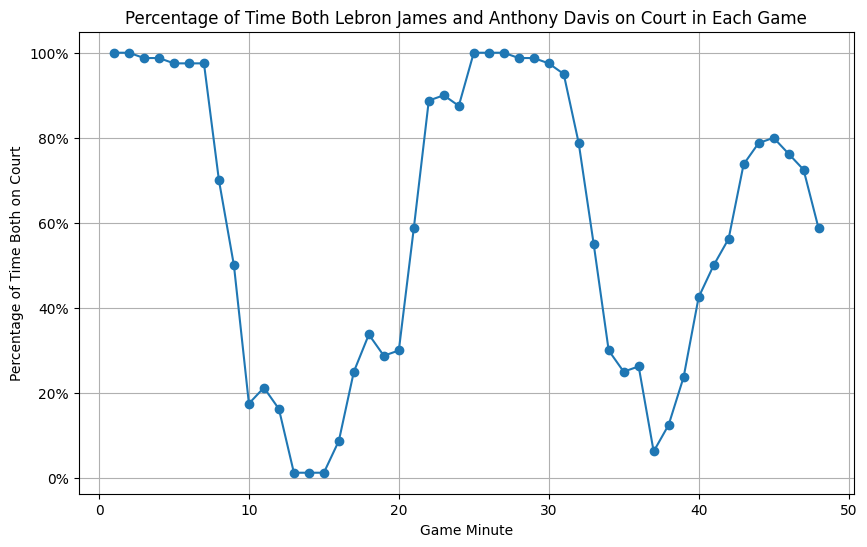

In [ ]:
# Ensure 'Game Minute' and 'percentage' are numeric types
lbj_ad_time['Game Minute'] = pd.to_numeric(lbj_ad_time['Game Minute'])
lbj_ad_time['percentage'] = pd.to_numeric(lbj_ad_time['percentage'])

# Function to format y-axis ticks as percentages
def percent_formatter(x, pos):
    return f'{x:.0%}'

# Time Series Plot
plt.figure(figsize=(10, 6))
plt.plot(lbj_ad_time['Game Minute'], lbj_ad_time['percentage'], marker='o', linestyle='-')
plt.title('Percentage of Time Both Lebron James and Anthony Davis on Court in Each Game')
plt.xlabel('Game Minute')
plt.ylabel('Percentage of Time Both on Court')

# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.grid(True)
plt.show()

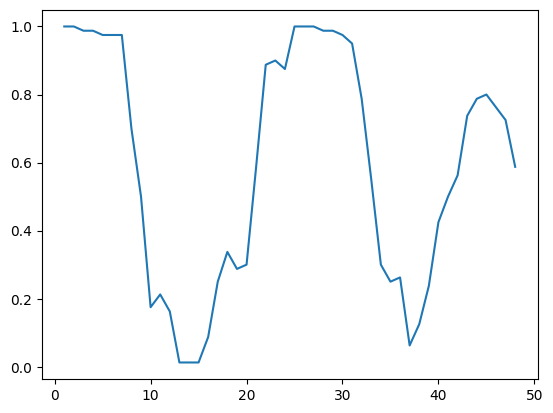

In [ ]:
plt.plot(lbj_ad_time['Game Minute'], lbj_ad_time['percentage'], linestyle='-', label='Both (LBJ and AD)')

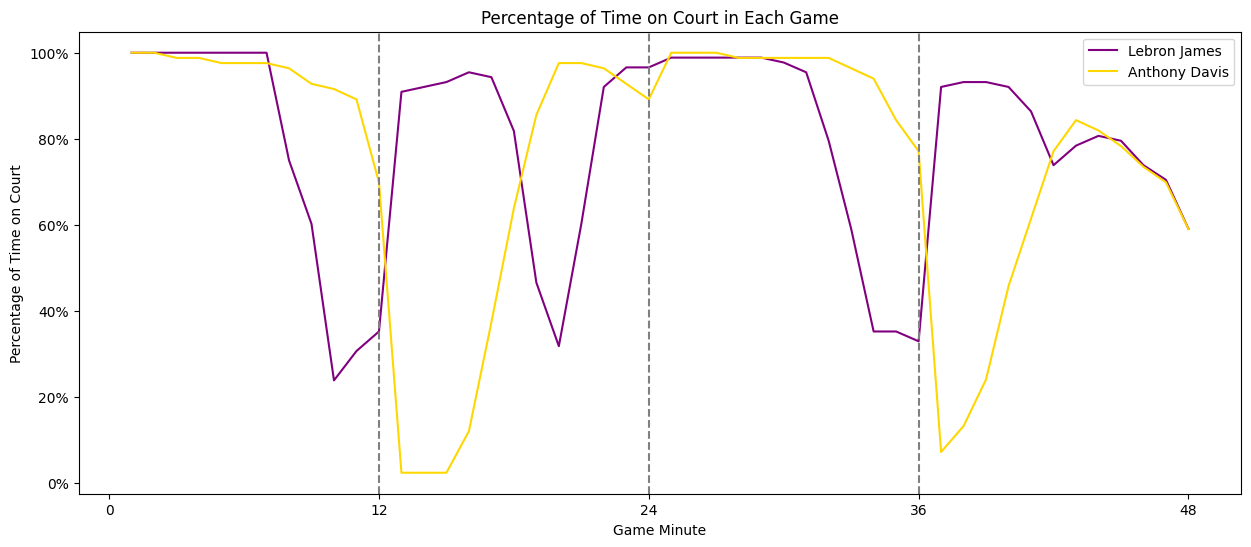

In [ ]:
# Assuming your DataFrames are named lbj_ad_time, lbj_time, and ad_time
# Ensure 'Game Minute' and 'percentage' are numeric types
lbj_ad_time['Game Minute'] = pd.to_numeric(lbj_ad_time['Game Minute'])
lbj_ad_time['percentage'] = pd.to_numeric(lbj_ad_time['percentage'])

lbj_time['Game Minute'] = pd.to_numeric(lbj_time['Game Minute'])
lbj_time['percentage'] = pd.to_numeric(lbj_time['percentage'])

ad_time['Game Minute'] = pd.to_numeric(ad_time['Game Minute'])
ad_time['percentage'] = pd.to_numeric(ad_time['percentage'])

# Function to format y-axis ticks as percentages
def percent_formatter(x, pos):
    return f'{x:.0%}'

# Time Series Plot
plt.figure(figsize=(15, 6))

# Plot each line with different colors and labels
# plt.plot(lbj_ad_time['Game Minute'], lbj_ad_time['percentage'], marker='o', linestyle='-', label='Both (LBJ and AD)')
plt.plot(lbj_time['Game Minute'], lbj_time['percentage'], linestyle='-', label='Lebron James', color = 'purple')
plt.plot(ad_time['Game Minute'], ad_time['percentage'], linestyle='-', label='Anthony Davis', color = 'gold')

plt.title('Percentage of Time on Court in Each Game')
plt.xticks([0, 12, 24, 36, 48])
plt.xlabel('Game Minute')
plt.ylabel('Percentage of Time on Court')

# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Show legend
plt.legend()

# Draw vertical lines at 12, 24, and 36 minutes
plt.axvline(x=12, color='gray', linestyle='--', label='12 Minutes')
plt.axvline(x=24, color='gray', linestyle='--', label='24 Minutes')
plt.axvline(x=36, color='gray', linestyle='--', label='36 Minutes')

plt.grid(False)
plt.show()


#### Add the in-game +/- per min to the graph

In [ ]:
LBJAD_games = lakers[lakers['GameFile'].isin(lebron_and_anthony_davis['GameFile'])]

In [ ]:
LBJAD_games.shape

(37763, 46)

In [ ]:
LBJAD_games['GameFile'].nunique()

80

In [ ]:
LBJAD_games[['elapsed', 'remaining_time']]

,elapsed,remaining_time
11510,00:00:00,00:12:00
11511,00:00:00,00:12:00
11512,00:00:19,00:11:41
11513,00:00:34,00:11:26
11514,00:00:52,00:11:08
...,...,...
535063,0:04:39,0:00:21
535064,0:04:39,0:00:21
535065,0:04:49,0:00:11
535066,0:04:52,0:00:08


In [ ]:
LBJAD_games = LBJAD_games.copy()
#Create home and away team
LBJAD_games['away_team'] = LBJAD_games['GameFile'].apply(lambda x: x.split('@')[0][-3:])
LBJAD_games['home_team'] = LBJAD_games['GameFile'].apply(lambda x: x.split('@')[1].split('.')[0][:3])
LBJAD_games['minute'] = LBJAD_games['elapsed'].apply(
    lambda x: x[x.find(':') + 1:x.find(':') + 3] if np.any(LBJAD_games['period'] == 5) else x[x.find(':') + 1:x.find(':') + 3]
)
LBJAD_games['minute'].replace('12', '11', inplace=True)

In [ ]:
PlusMinus_min = LBJAD_games[['GameFile', 'remaining_time', 'minute', 'away_team', 'home_team', 'home_score', 'away_score', 'period']]

In [ ]:
#Exclude overtime
PlusMinus_min = PlusMinus_min[PlusMinus_min['period'] != 5]
PlusMinus_min[['period']].value_counts()

period
2         9734
4         9557
3         9224
1         9149
dtype: int64

In [ ]:
#Calculate game minute
PlusMinus_min['minute'] = pd.to_numeric(PlusMinus_min['minute'])
PlusMinus_min['Game minute'] = PlusMinus_min['minute'] + (PlusMinus_min['period']-1)*12 +1

In [ ]:
PlusMinus_min[['period', 'minute', 'Game minute']]

,period,minute,Game minute
11510,1,0,1
11511,1,0,1
11512,1,0,1
11513,1,0,1
11514,1,0,1
...,...,...,...
535009,4,11,48
535010,4,11,48
535011,4,11,48
535012,4,11,48


In [ ]:
PlusMinus_min.drop_duplicates(subset=['Game minute', 'GameFile'], keep='last', inplace=True)

In [ ]:
PlusMinus_min

,GameFile,remaining_time,minute,away_team,home_team,home_score,away_score,period,Game minute
11516,[2020-01-03]-0021900522-NOP@LAL.csv,00:11:06,0,NOP,LAL,4,3,1,1
11527,[2020-01-03]-0021900522-NOP@LAL.csv,00:10:04,1,NOP,LAL,6,8,1,2
11538,[2020-01-03]-0021900522-NOP@LAL.csv,00:09:02,2,NOP,LAL,9,8,1,3
11544,[2020-01-03]-0021900522-NOP@LAL.csv,00:08:07,3,NOP,LAL,14,10,1,4
11557,[2020-01-03]-0021900522-NOP@LAL.csv,00:07:03,4,NOP,LAL,18,12,1,5
...,...,...,...,...,...,...,...,...,...
534972,[2019-11-01]-0021900074-LAL@DAL.csv,0:04:06,7,LAL,DAL,94,96,4,44
534982,[2019-11-01]-0021900074-LAL@DAL.csv,0:03:15,8,LAL,DAL,97,98,4,45
534987,[2019-11-01]-0021900074-LAL@DAL.csv,0:02:18,9,LAL,DAL,99,98,4,46
534994,[2019-11-01]-0021900074-LAL@DAL.csv,0:01:01,10,LAL,DAL,99,100,4,47


In [ ]:
PlusMinus_min['acc_lead'] = PlusMinus_min.apply(lambda row: row['home_score'] - row['away_score'] if row['home_team'] == 'LAL' else row['away_score'] - row['home_score'], axis=1)


In [ ]:
PlusMinus_min

,GameFile,remaining_time,minute,away_team,home_team,home_score,away_score,period,Game minute,acc_lead
11516,[2020-01-03]-0021900522-NOP@LAL.csv,00:11:06,0,NOP,LAL,4,3,1,1,1
11527,[2020-01-03]-0021900522-NOP@LAL.csv,00:10:04,1,NOP,LAL,6,8,1,2,-2
11538,[2020-01-03]-0021900522-NOP@LAL.csv,00:09:02,2,NOP,LAL,9,8,1,3,1
11544,[2020-01-03]-0021900522-NOP@LAL.csv,00:08:07,3,NOP,LAL,14,10,1,4,4
11557,[2020-01-03]-0021900522-NOP@LAL.csv,00:07:03,4,NOP,LAL,18,12,1,5,6
...,...,...,...,...,...,...,...,...,...,...
534972,[2019-11-01]-0021900074-LAL@DAL.csv,0:04:06,7,LAL,DAL,94,96,4,44,2
534982,[2019-11-01]-0021900074-LAL@DAL.csv,0:03:15,8,LAL,DAL,97,98,4,45,1
534987,[2019-11-01]-0021900074-LAL@DAL.csv,0:02:18,9,LAL,DAL,99,98,4,46,-1
534994,[2019-11-01]-0021900074-LAL@DAL.csv,0:01:01,10,LAL,DAL,99,100,4,47,1


In [ ]:
plusminus = PlusMinus_min.groupby(['Game minute'])[['acc_lead']].sum().reset_index()

In [ ]:
plusminus['avg_acc_lead'] = round(plusminus['acc_lead']/80,2)
plusminus['lead'] = plusminus['acc_lead'] - plusminus['acc_lead'].shift(1)
plusminus.loc[0,'lead'] = plusminus.loc[0,'acc_lead']
plusminus['avg_lead'] = round(plusminus['lead']/80,2)

In [ ]:
plusminus

,Game minute,acc_lead,avg_acc_lead,lead,avg_lead
0,1,12,0.15,12.0,0.15
1,2,13,0.16,1.0,0.01
2,3,24,0.30,11.0,0.14
3,4,85,1.06,61.0,0.76
4,5,75,0.94,-10.0,-0.12
5,6,112,1.40,37.0,0.46
6,7,113,1.41,1.0,0.01
7,8,141,1.76,28.0,0.35
8,9,213,2.66,72.0,0.90
9,10,203,2.54,-10.0,-0.12


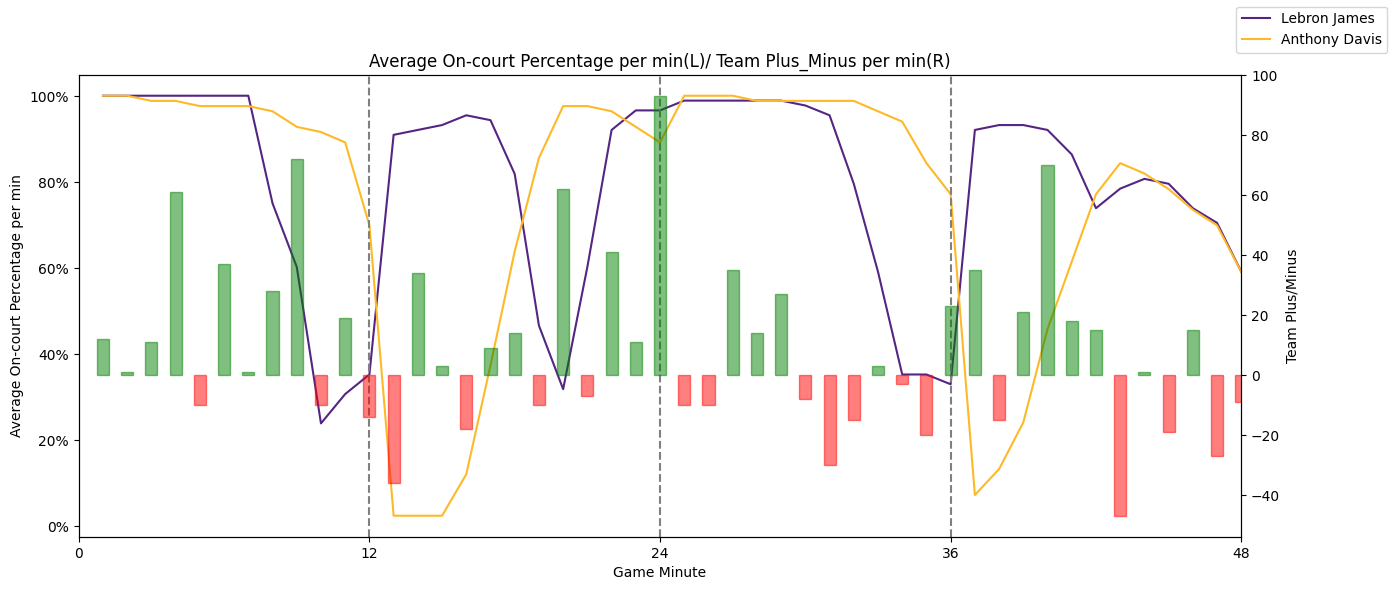

In [ ]:
# Function to format y-axis ticks as percentages
def percent_formatter(x, pos):
    return f'{x:.0%}'

# Time Series Plot
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot each line with different colors and labels
ax1.plot(lbj_time['Game Minute'], lbj_time['percentage'], linestyle='-', label='Lebron James', color='#552583')
ax1.plot(ad_time['Game Minute'], ad_time['percentage'], linestyle='-', label='Anthony Davis', color='#FDB927')

# Set the x-axis limits based on the data
ax1.set_xlim([0, max(lbj_time['Game Minute'].max(), ad_time['Game Minute'].max())])

ax1.set_title('Average On-court Percentage per min(L)/ Team Plus_Minus per min(R)')
ax1.set_xticks([0, 12, 24, 36, 48])
ax1.set_xlabel('Game Minute')
ax1.set_ylabel('Average On-court Percentage per min')

# Apply the percentage formatter to the y-axis
ax1.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Create a secondary y-axis for the bar chart
ax2 = ax1.twinx()

# Plot the bar chart with conditional colors
bars = ax2.bar(plusminus['Game minute'], plusminus['lead'], alpha =0.5, width=0.5)

# Set the color of the bars based on the values
for bar, value in zip(bars, plusminus['lead']):
    if value > 0:
        bar.set_color('green')
    else:
        bar.set_color('red')

ax2.set_ylabel('Team Plus/Minus')

# Show legend
fig.legend()

# Draw vertical lines at 12, 24, and 36 minutes
ax1.axvline(x=12, color='gray', linestyle='--', label='12 Minutes')
ax1.axvline(x=24, color='gray', linestyle='--', label='24 Minutes')
ax1.axvline(x=36, color='gray', linestyle='--', label='36 Minutes')

plt.grid(False)
plt.show()


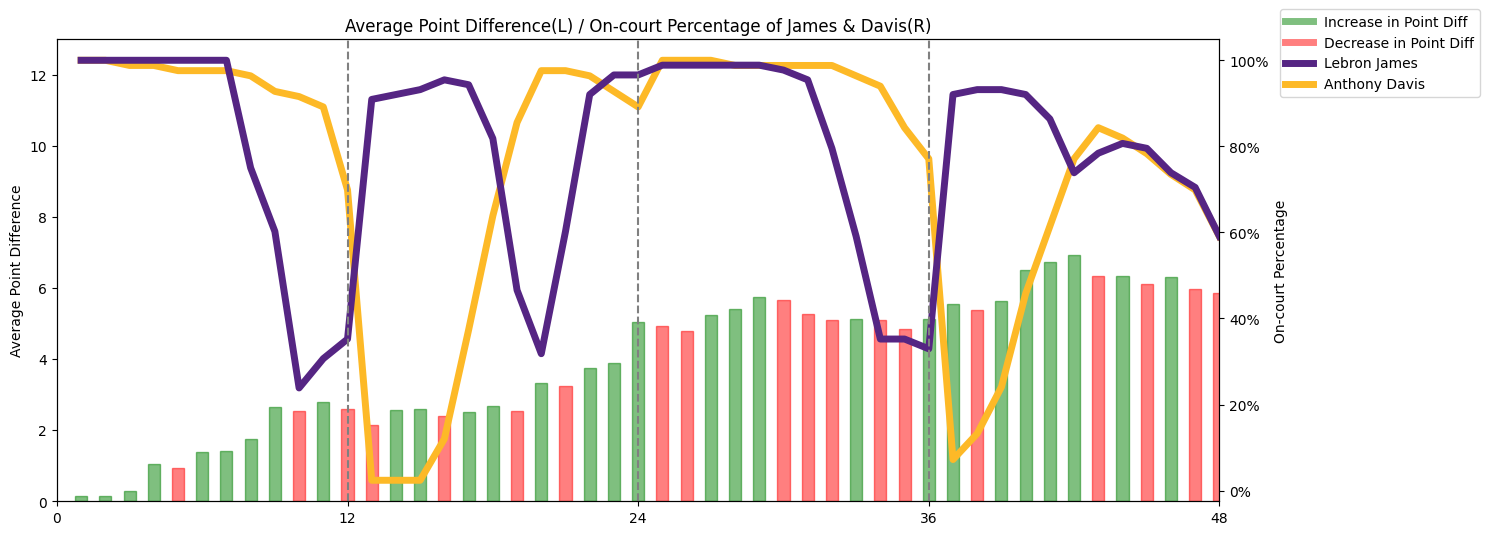

In [ ]:
# Function to format y-axis ticks as percentages
def percent_formatter(x, pos):
    return f'{x:.0%}'

# Time Series Plot
fig, ax1 = plt.subplots(figsize=(15, 6))

# Create a secondary y-axis for the bar chart
ax2 = ax1.twinx()

# Plot the bar chart with conditional colors
bars = ax1.bar(plusminus['Game minute'], plusminus['avg_acc_lead'], width=0.5, alpha=0.5)

# Set the color of the bars based on the values
for bar, value in zip(bars, plusminus['lead']):
    if value > 0:
        bar.set_color('green')
    else:
        bar.set_color('red')

# Create legends for the bar chart bars
green_patch = plt.Line2D([0], [0], color='green', linestyle='-', linewidth = 5, alpha = 0.5)
red_patch = plt.Line2D([0], [0], color='red', linestyle='-', linewidth = 5, alpha = 0.5)

# Plot each line with different colors and labels
line1, = ax2.plot(lbj_time['Game Minute'], lbj_time['percentage'], linestyle='-', color='#552583', linewidth=5, zorder = 1)
line2, = ax2.plot(ad_time['Game Minute'], ad_time['percentage'], linestyle='-', color='#FDB927', linewidth=5, zorder = 0)

# Combine legends into a single legend box
handles, labels = ax1.get_legend_handles_labels()
handles.extend([green_patch, red_patch, line1, line2])
labels.extend(['Increase in Point Diff', 'Decrease in Point Diff', 'Lebron James', 'Anthony Davis'])
ax1.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.23, 1.08))

ax1.set_ylabel('Average Point Difference')
ax1.set_ylim(0, 13)

# Set the x-axis limits based on the data
ax2.set_xlim([0, max(lbj_time['Game Minute'].max(), ad_time['Game Minute'].max())])

ax2.set_title('Average Point Difference(L) / On-court Percentage of James & Davis(R)')
ax2.set_xticks([0, 12, 24, 36, 48])
ax2.set_xlabel('Game Minute')
ax2.set_ylabel('On-court Percentage')

# Apply the percentage formatter to the y-axis
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Draw vertical lines at 12, 24, and 36 minutes
ax2.axvline(x=12, color='gray', linestyle='--', label='12 Minutes')
ax2.axvline(x=24, color='gray', linestyle='--', label='24 Minutes')
ax2.axvline(x=36, color='gray', linestyle='--', label='36 Minutes')

plt.grid(False)
plt.show()

#### Who replace **Lebron James**

In [ ]:
lbj_left = df.copy()

# Extract minutes from 'elapsed' timestamp
lbj_left['minute'] = lbj_left['elapsed'].apply(
    lambda x: x[x.find(':') + 1:x.find(':') + 3] if np.any(lbj_left['period'] == 5) else x[x.find(':') + 1:x.find(':') + 3]
)

In [ ]:
lbj_left['minute'].replace('12', '11', inplace=True)

In [ ]:
lbj_left = lbj_left[lbj_left['left'] == 'LeBron James']

In [ ]:
# Total number of substitution
lbj_left['entered'].count()

In [ ]:
lbj_left['entered'].value_counts()

#### Who replace **Anthony Davis**

In [ ]:
ad_left = df.copy()

# Extract minutes from 'elapsed' timestamp
ad_left['minute'] = ad_left['elapsed'].apply(
    lambda x: x[x.find(':') + 1:x.find(':') + 3] if np.any(ad_left['period'] == 5) else x[x.find(':') + 1:x.find(':') + 3]
)

In [ ]:
ad_left['minute'].replace('12', '11', inplace=True)

In [ ]:
ad_left = ad_left[ad_left['left'] == 'Anthony Davis']

In [ ]:
ad_left['entered'].count()

In [ ]:
ad_left['entered'].value_counts()

## **Part B**
#### Compare team performance when Lebron and AD are on and off the court

#### part B setup

In [ ]:
## find Lakers game
lakers_games = df[df['GameFile'].str.contains("LAL")]

In [ ]:
col = ['a1', 'a2', 'a3', 'a4', 'a5', 'h1', 'h2', 'h3', 'h4', 'h5']

lebron_mask = lakers_games[col].apply(lambda row: 'LeBron James' in row.values, axis=1)
anthony_davis_mask = lakers_games[col].apply(lambda row: 'Anthony Davis' in row.values, axis=1)

# Filter the DataFrame for rows where both LeBron James and Anthony Davis are on the court
lebron_and_anthony_davis = lakers_games[lebron_mask & anthony_davis_mask]

In [ ]:
lebron = lakers_games[lebron_mask & ~anthony_davis_mask]
AD = lakers_games[anthony_davis_mask & ~lebron_mask]
No_stars = lakers_games[~lebron_mask & ~anthony_davis_mask]

#### Possessions

Formula:0.96*[(Field Goal Attempts)+(Turnovers)+0.44*(Free Throw Attempts)-(Offensive Rebounds)]


In [ ]:
lebron_and_anthony_davis[(lebron_and_anthony_davis['team'] != 'LAL') &(lebron_and_anthony_davis['type'] == 'team rebound') & lebron_and_anthony_davis['description'].str.contains('Lakers', case = False)][['team', 'description', 'elapsed']]

,team,description,elapsed
11550,NaN,LAKERS Rebound,00:04:43
11726,NaN,LAKERS Rebound,00:11:27
11777,NaN,LAKERS Rebound,00:05:18
12448,NaN,LAKERS Rebound,00:02:04
12464,NaN,LAKERS Rebound,00:04:46
...,...,...,...
532937,NaN,LAKERS Rebound,00:04:24
533053,NaN,LAKERS Rebound,00:03:59
533062,NaN,LAKERS Rebound,00:04:51
534936,NaN,Lakers Rebound,0:03:58


In [ ]:
lebron_and_anthony_davis[pd.isnull(lebron_and_anthony_davis['team'])][['type']].value_counts()

type                              
team rebound                          287
 timeout: regular                     225
start of period                       168
end of period                         123
unknown                                88
turnover: shot clock                   23
uknown                                 22
violation: delay of game violation      7
foul                                    6
jump ball                               2
5 second violation                      1
8 second violation                      1
dtype: int64

In [ ]:
#LBJ +AD
LAL_events = lebron_and_anthony_davis[lebron_and_anthony_davis['team'] == 'LAL']
FGA = (LAL_events['event_type'] == 'shot').sum() + (LAL_events['event_type'] == 'miss').sum()
TOV = (LAL_events['event_type'] == 'turnover').sum() \
       + ((lebron_and_anthony_davis['event_type'] == 'turnover') & (lebron_and_anthony_davis['description'].str.contains('Lakers', case = False))\
          & pd.isnull(lebron_and_anthony_davis['team'])).sum()
FTA = (LAL_events['event_type'] == 'free throw').sum()
OREB = ((LAL_events['event_type'] == 'rebound') & (LAL_events['type'] == 'rebound offensive')).sum()\
    #  + ((lebron_and_anthony_davis['event_type'] == 'rebound') & (lebron_and_anthony_davis['description'].str.contains('Lakers', case = False))).sum()
LBJAD_poss = 0.96*(FGA + TOV + 0.44*FTA - OREB)

In [ ]:
LBJAD_poss

4088.140799999999

In [ ]:
#LBJ
LAL_events = lebron[lebron['team'] == 'LAL']
FGA = (LAL_events['event_type'] == 'shot').sum() + (LAL_events['event_type'] == 'miss').sum()
TOV = (LAL_events['event_type'] == 'turnover').sum() \
       + ((lebron['event_type'] == 'turnover') & (lebron['description'].str.contains('Lakers', case = False)) \
        & pd.isnull(lebron['team'])).sum()
FTA = (LAL_events['event_type'] == 'free throw').sum()
OREB = ((LAL_events['event_type'] == 'rebound') & (LAL_events['type'] == 'rebound offensive')).sum()
LBJ_poss = 0.96*(FGA + TOV + 0.44*(FTA - OREB))

In [ ]:
LBJ_poss

2223.1296

In [ ]:
#AD
LAL_events = AD[AD['team'] == 'LAL']
FGA = (LAL_events['event_type'] == 'shot').sum() + (LAL_events['event_type'] == 'miss').sum()
TOV = (LAL_events['event_type'] == 'turnover').sum() \
    + ((AD['event_type'] == 'turnover') & (AD['description'].str.contains('Lakers', case = False))\
       & pd.isnull(AD['team'])).sum()
FTA = (LAL_events['event_type'] == 'free throw').sum()
OREB = ((LAL_events['event_type'] == 'rebound') & (LAL_events['type'] == 'rebound offensive')).sum()
AD_poss = 0.96*(FGA + TOV + 0.44*(FTA - OREB))

In [ ]:
AD_poss

1927.5648

In [ ]:
#Both out
LAL_events = No_stars[No_stars['team'] == 'LAL']
FGA = (LAL_events['event_type'] == 'shot').sum() + (LAL_events['event_type'] == 'miss').sum()
TOV = (LAL_events['event_type'] == 'turnover').sum() \
    + ((No_stars['event_type'] == 'turnover') & (No_stars['description'].str.contains('Lakers', case = False))\
    & pd.isnull(No_stars['team'])).sum()
FTA = (LAL_events['event_type'] == 'free throw').sum()
OREB = ((LAL_events['event_type'] == 'rebound') & (LAL_events['type'] == 'rebound offensive')).sum()
No_stars_poss = 0.96*(FGA + TOV + 0.44*(FTA - OREB))

In [ ]:
No_stars_poss

1013.5679999999999

#### Estimated plus/minus per 100 possessions (EPM)


In [ ]:
#LBJ+AD
LBJAD_off = lebron_and_anthony_davis[lebron_and_anthony_davis['team'] == 'LAL']['points'].sum()
LBJAD_def = lebron_and_anthony_davis[lebron_and_anthony_davis['team'] != 'LAL']['points'].sum()

In [ ]:
LBJAD_PM = LBJAD_off - LBJAD_def
LBJAD_EPM = LBJAD_PM/LBJAD_poss*100
LBJAD_EPM

10.444845735254521

In [ ]:
#LBJ
LBJ_off = lebron[lebron['team'] == 'LAL']['points'].sum()
LBJ_def = lebron[lebron['team'] != 'LAL']['points'].sum()

In [ ]:
LBJ_PM = LBJ_off - LBJ_def
LBJ_EPM = LBJ_PM/LBJ_poss*100
LBJ_EPM

8.0966939579231

In [ ]:
#AD
AD_off = AD[AD['team'] == 'LAL']['points'].sum()
AD_def = AD[AD['team'] != 'LAL']['points'].sum()

In [ ]:
AD_PM = AD_off - AD_def
AD_EPM = AD_PM/AD_poss*100
AD_EPM

-0.10375786069552628

In [ ]:
#Both out
No_stars_off = No_stars[No_stars['team'] == 'LAL']['points'].sum()
No_stars_def = No_stars[No_stars['team'] != 'LAL']['points'].sum()

In [ ]:
No_stars_PM = No_stars_off - No_stars_def
No_stars_EPM = No_stars_PM/No_stars_poss*100
No_stars_EPM

-4.93306813159058

#### Off, Def and Net ratings

In [ ]:
#LBJ+AD opp poss
opp_events = lebron_and_anthony_davis[lebron_and_anthony_davis['team'] != 'LAL']
FGA = (opp_events['event_type'] == 'shot').sum() + (opp_events['event_type'] == 'miss').sum()
TOV = (opp_events['event_type'] == 'turnover').sum()\
       - ((opp_events['event_type'] == 'turnover') & (opp_events['description'].str.contains('Lakers', case = False))\
       & pd.isnull(opp_events['team'])).sum()
FTA = (opp_events['event_type'] == 'free throw').sum()
OREB = ((opp_events['event_type'] == 'rebound') & (opp_events['type'] == 'rebound offensive')).sum()
LBJAD_opp_poss = 0.96*(FGA + TOV + 0.44*FTA - OREB)

In [ ]:
LBJAD_opp_poss

4087.4112

In [ ]:
LBJAD_offr = LBJAD_off/LBJAD_poss*100
LBJAD_defr = LBJAD_def/LBJAD_opp_poss*100
LBJAD_nr = LBJAD_offr -LBJAD_defr
LBJAD_nr

10.42566907468661

In [ ]:
#LBJ opp poss
opp_events = lebron[lebron['team'] != 'LAL']
FGA = (opp_events['event_type'] == 'shot').sum() + (opp_events['event_type'] == 'miss').sum()
TOV = (opp_events['event_type'] == 'turnover').sum()\
       - ((opp_events['event_type'] == 'turnover') & (opp_events['description'].str.contains('Lakers', case = False))\
       & pd.isnull(opp_events['team'])).sum()
FTA = (opp_events['event_type'] == 'free throw').sum()
OREB = ((opp_events['event_type'] == 'rebound') & (opp_events['type'] == 'rebound offensive')).sum()
LBJ_opp_poss = 0.96*(FGA + TOV + 0.44*FTA - OREB)

In [ ]:
LBJ_opp_poss

2089.344

In [ ]:
LBJ_offr = LBJ_off/LBJ_poss*100
LBJ_defr = LBJ_def/LBJ_opp_poss*100
LBJ_nr = LBJ_offr -LBJ_defr
LBJ_nr

1.4864524158370358

In [ ]:
#AD opp poss
opp_events = AD[AD['team'] != 'LAL']
FGA = (opp_events['event_type'] == 'shot').sum() + (opp_events['event_type'] == 'miss').sum()
TOV = (opp_events['event_type'] == 'turnover').sum()\
       - ((opp_events['event_type'] == 'turnover') & (opp_events['description'].str.contains('Lakers', case = False))\
       & pd.isnull(opp_events['team'])).sum()
FTA = (opp_events['event_type'] == 'free throw').sum()
OREB = ((opp_events['event_type'] == 'rebound') & (opp_events['type'] == 'rebound offensive')).sum()
AD_opp_poss = 0.96*(FGA + TOV + 0.44*FTA - OREB)

In [ ]:
AD_opp_poss

1798.4256

In [ ]:
AD_offr = AD_off/AD_poss*100
AD_defr = AD_def/AD_opp_poss*100
AD_nr = AD_offr -AD_defr
AD_nr

-7.88955197111558

In [ ]:
#Both out opp poss
opp_events = No_stars[No_stars['team'] != 'LAL']
FGA = (opp_events['event_type'] == 'shot').sum() + (opp_events['event_type'] == 'miss').sum()
TOV = (opp_events['event_type'] == 'turnover').sum()\
       - ((opp_events['event_type'] == 'turnover') & (opp_events['description'].str.contains('Lakers', case = False))\
       & pd.isnull(opp_events['team'])).sum()
FTA = (opp_events['event_type'] == 'free throw').sum()
OREB = ((opp_events['event_type'] == 'rebound') & (opp_events['type'] == 'rebound offensive')).sum()
No_stars_opp_poss = 0.96*(FGA + TOV + 0.44*FTA - OREB)

In [ ]:
No_stars_opp_poss

982.1184

In [ ]:
No_stars_offr = No_stars_off/No_stars_poss*100
No_stars_defr = No_stars_def/No_stars_opp_poss*100
No_stars_nr = No_stars_offr - No_stars_defr
No_stars_nr

-8.379924117320954

#### FG% of other teammates

In [ ]:
#Teammates FG% when LBJ + AD is on
LAL_events = lebron_and_anthony_davis[lebron_and_anthony_davis['team'] == 'LAL']
FG_tm = ((LAL_events['event_type'] == 'shot') & (LAL_events['player'] != 'LeBron James') & (LAL_events['player'] != 'Anthony Davis')).sum()
FGm_tm = ((LAL_events['event_type'] == 'miss') & (LAL_events['player'] != 'LeBron James') & (LAL_events['player'] != 'Anthony Davis')).sum()
LBJAD_FGpct_tm = FG_tm/(FG_tm + FGm_tm)*100
LBJAD_FGpct_tm

46.25074985002999

In [ ]:
#Teammate FG% when only LBJ is on
LAL_events = lebron[lebron['team'] == 'LAL']
FG_tm = ((LAL_events['event_type'] == 'shot') & (LAL_events['player'] != 'LeBron James')).sum()
FGm_tm = ((LAL_events['event_type'] == 'miss') & (LAL_events['player'] != 'LeBron James')).sum()
LBJ_FGpct_tm = FG_tm/(FG_tm + FGm_tm)*100
LBJ_FGpct_tm

48.27862289831866

In [ ]:
#Teammate FG% when only AD is on
LAL_events = AD[AD['team'] == 'LAL']
FG_tm = ((LAL_events['event_type'] == 'shot') & (LAL_events['player'] != 'Anthony Davis')).sum()
FGm_tm = ((LAL_events['event_type'] == 'miss') & (LAL_events['player'] != 'Anthony Davis')).sum()
AD_FGpct_tm = FG_tm/(FG_tm + FGm_tm)*100
AD_FGpct_tm

44.12296564195298

In [ ]:
#Teammate FG% when both out
LAL_events = No_stars[No_stars['team'] == 'LAL']
FG_tm = (LAL_events['event_type'] == 'shot').sum()
FGm_tm = (LAL_events['event_type'] == 'miss').sum()
No_stars_FGpct_tm = FG_tm/(FG_tm + FGm_tm)*100
No_stars_FGpct_tm

45.06880733944954

In [ ]:
ratings = pd.DataFrame({'Split_type': ['LeBron + AD', 'LeBron', 'AD', 'Both out'],
        'Offensive_ratings': [LBJAD_offr, LBJ_offr, AD_offr, No_stars_offr],
        'Defensive_ratings': [LBJAD_defr, LBJ_defr, AD_defr, No_stars_defr],
        'Net_ratings': [LBJAD_nr, LBJ_nr, AD_nr, No_stars_nr],
        'Plus/Minus': [LBJAD_EPM, LBJ_EPM, AD_EPM, No_stars_EPM],
        'Teammate_FG%': [LBJAD_FGpct_tm, LBJ_FGpct_tm, AD_FGpct_tm, No_stars_FGpct_tm]})
numeric_columns = ratings.select_dtypes(include=['float64', 'int64']).columns
ratings[numeric_columns] = ratings[numeric_columns].round(2)

ratings

,Split_type,Offensive_ratings,Defensive_ratings,Net_ratings,Plus/Minus,Teammate_FG%
0,LeBron + AD,117.88,107.45,10.43,10.44,46.25
1,LeBron,111.33,109.84,1.49,8.10,48.28
2,AD,108.32,116.21,-7.89,-0.10,44.12
3,Both out,102.71,111.09,-8.38,-4.93,45.07
